In [1]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
from ipynb.fs.full.All_Functions import ParamsPrep
%matplotlib inline

In [2]:
def StandardDoseTimeSim(TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, tstart, in enumerate(TrtmntStrtDay):
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X.append(np.log10(np.maximum(V,10**2)))
        X[idi][X[idi]==2]=1
        times.append(t)
    return X, times

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
## --------------------- PK parameters -----------------------------
Indparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRestimatedIndividualParameters.txt'
Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'
Indparameters_NIR = pd.read_csv(Indparameters_U_file)
Popparameters_NIR = pd.read_csv(Popparameters_U_file)

IDs = Indparameters_NIR.id.unique()

data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Data/NIR/NIR_Ret_250mg.csv'
Data_NIR = pd.read_csv(data_file)

In [13]:
Data_NIR_Clean = Data_NIR.dropna(subset=['Concentration'])

In [14]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol
dose =300

In [15]:
def SimulateTreatmentPK(PK_Model, init, tzero, dt, tend, PKPDInd, dose, dosetimes):

    #Nirmatrelvir PK Parameters for each individual
    ka = PKPDInd['ka']/24
    k12 = PKPDInd['kPL']/24
    k21 = PKPDInd['kLP']/24
    kcl = PKPDInd['kCl']/24
    PKparams = [ka, k12, kcl, k21]
    args = tuple(PKparams)
    if len(dosetimes) == 1:
        init[0] = init[0] + dose 
        t = np.arange(0,tend,dt)
        y = spi.odeint(PK_Model, init, t, args = args)
    else:
        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init[0] = init[0] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(PK_Model, init, ttemp, args = args)
            if j==0:
                y=ytemp
                t=ttemp
            else:
                t = np.concatenate((t,ttemp))
                y = np.concatenate((y,ytemp), axis = 0)     
            init = ytemp[-1,:].T
        #simulate until tend
        init = ytemp[-1,:].T
        init[0] = init[0] + dose 
        ttemp = np.arange(dosetimes[-1],tend,dt)
        ytemp = spi.odeint(PK_Model, init, ttemp, args = args)
        t = np.concatenate((t,ttemp))
        y = np.concatenate((y,ytemp), axis = 0)
    return t, y

In [16]:
fig = plt.figure(figsize = (20,15))
plt.rcParams.update({'font.size': 25})
dose = 250*10**6 #ng
init = [0,0,0]
T_end = 24
num_dose = 1
dt = 0.001
dosetimes = np.arange(0,T_end,T_end/num_dose)
A_P = []
for cc, id in enumerate(IDs):
    init = [0,0,0]
    PKInd = GetVLIndParams(Indparameters_NIR, id, style = 'mode')
    t, y = SimulateTreatmentPK(PK_Model, init, 0, dt, T_end, PKInd, dose, dosetimes)
    Ag_NIR, A1_NIR, A2_NIR = (y).T
    A_P.append(A1_NIR)

<Figure size 1440x1080 with 0 Axes>

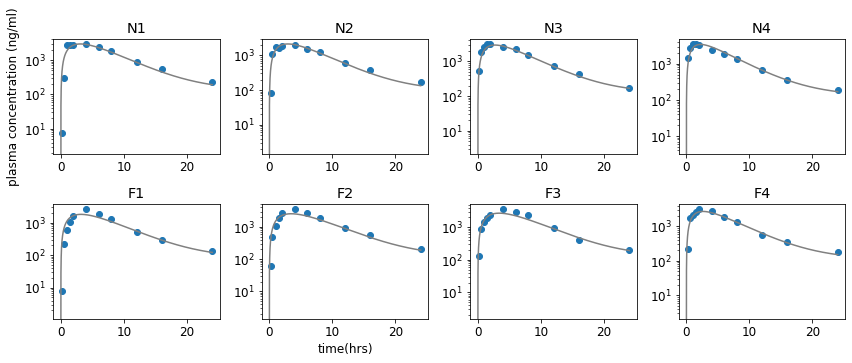

In [17]:
fig = plt.figure(figsize = (12,5))
plt.rcParams.update({'font.size': 12})
dose = 250*10**6 #mg
init = [0,0,0]
T_end = 24
num_dose = 1
dt = 0.001
dosetimes = np.arange(0,T_end,T_end/num_dose)
for cc, id in enumerate(IDs):
    PKInd = GetVLIndParams(Indparameters_NIR, id, style = 'mode')
    Data = Data_NIR_Clean[(Data_NIR_Clean.Id == id)]
    t_Data = Data['Time(hr)']
    Conc_Data = Data['Concentration']
    plt.subplot(2,4,cc+1)
    plt.semilogy(t_Data, Conc_Data, 'o')
    plt.plot(t, A_P[cc]/PKInd['Vol'], color = 'grey')
    plt.title(str(id))
    if cc == 5:
        plt.xlabel('time(hrs)')
    if cc == 0:
        plt.ylabel('plasma concentration (ng/ml)')
plt.tight_layout()